# Защита персональных данных клиентов

Нужно защитить данные клиентов страховой компании.  
Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.  
Обоснуем корректность его работы.  
При преобразовании, качество моделей машинного обучения не должно ухудшаться.

**Описание данных:**  
`Пол`  
`Возраст`  
`Зарплата`  
`Члены семьи`  
**Целевой признак:**  
`Страховые выплаты` клиенту за последние 5 лет

## Загрузка данных

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('insurance.csv')

### Знакомство с данными

In [3]:
df.sample(n=10, random_state=42)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
1501,1,28.0,56100.0,0,0
2586,1,32.0,41900.0,2,0
2653,1,30.0,26300.0,0,0
1055,1,30.0,37300.0,2,0
705,0,44.0,30000.0,1,1
106,1,45.0,41600.0,2,1
589,1,28.0,32800.0,2,0
2468,1,32.0,20600.0,2,0
2413,1,30.0,42600.0,2,0
1600,1,27.0,40700.0,0,0


Количество членов семьи начинается с нуля.  
Можно предположить что:  
`0` это одинокий клиент  
`1` это клиент в браке  
`>= 2` это дети  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропусков нет.  
Расход памяти небольшой - оптимизация не требуется.

In [5]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.50,0.50,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.95,8.44,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.36,9900.08,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.19,1.09,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.15,0.46,0.0,0.0,0.0,0.0,5.0


Вероятность наступления страхового случая у среднего клиента составляет `15%`  
Страховые выплаты находятся в четвертом квартиле по возрасту, `>37 лет`

In [6]:
print('Доля полных дубликатов в выборке составляет: {:3.2%}'.format(df.duplicated().mean()))

Доля полных дубликатов в выборке составляет: 3.06%


Так как у нас стоит задача шифровки данных, а не улучшения модели, мы не будем трогать дубликаты.

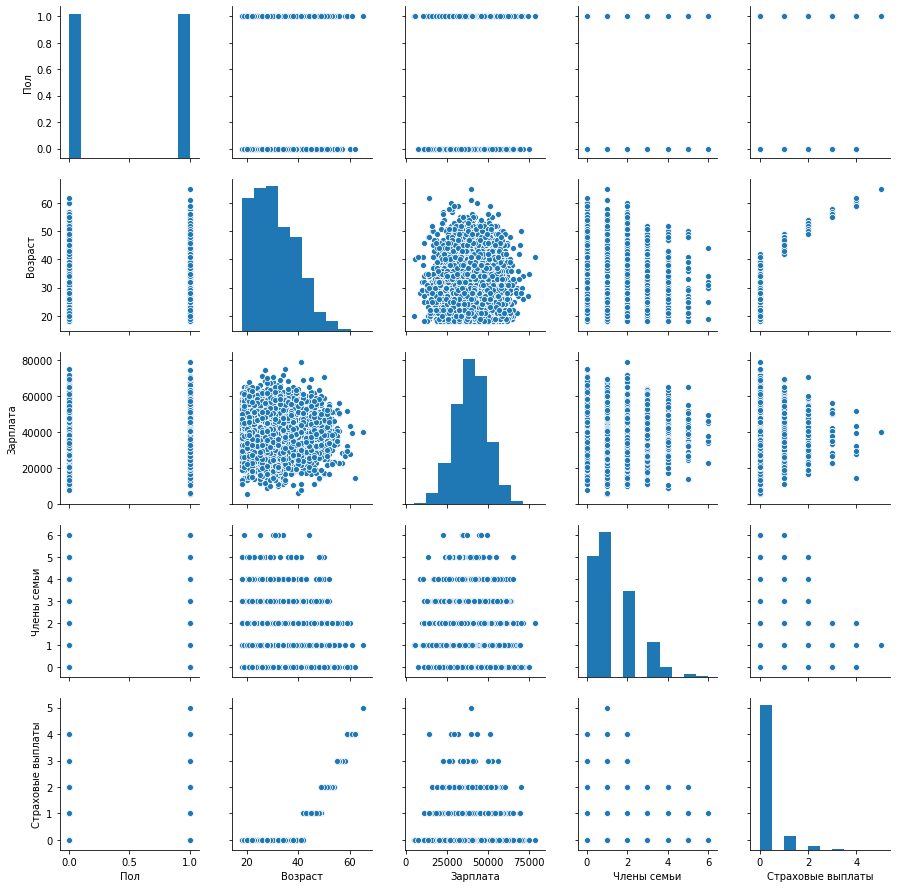

In [7]:
sns.pairplot(df);

Каждый пол в выборке встречается примерно одинаковое количество раз.  
Распределение по возрасту выглядит правдоподобно, чаще встречаются младшие клиенты.  
Зарплата распределена нормально.  
По нашшему предположению о членах семьи, чаще встречаются женатые клиенты.  
Большее количество выплат встречается у пола `1`  
Как мы и предполагали, страховые выплаты начинаются примерно с сорока лет, еще видно что они возрастают по прямой.  
Количество выплат более двух встречается только при количестве членов семьи менее трех.  
Так как у нас стоит задача шифровки данных, а не улучшения модели, мы не будем разделять признак количества членов семьи на две группы.  

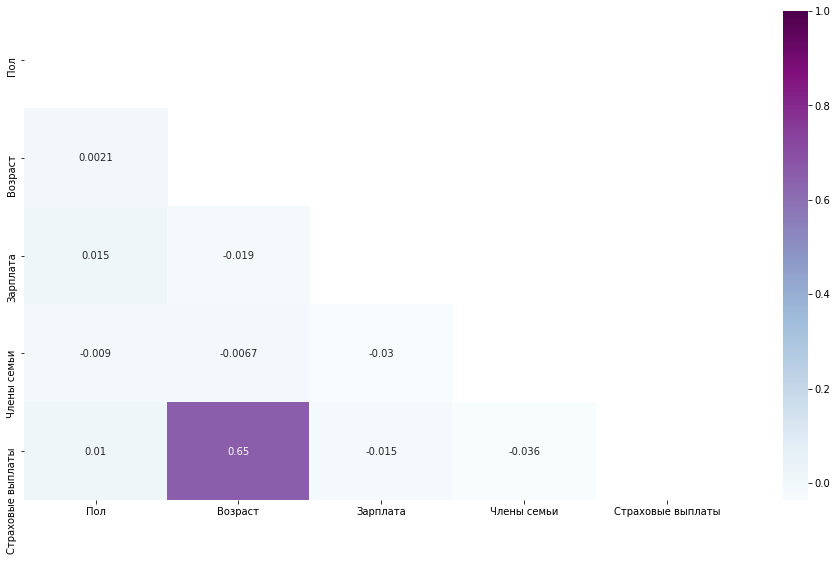

In [8]:

matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='BuPu');
    

Выделяется корреляция страховых выплат с возрастом.  

### Вывод:

Мы загрузили и познакомились с данными.  
Еще мы нашли темы для размышления помимо основной задачи.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:**  
Качество модели линейной регрессии не изменится. 

**Обоснование:**  
Линейная регрессия обучается получением вектора весов на исходной матрице признаков `X`   
Предсказания делаются уже на новой матрице признаков `X1`, давайте подставим ее в формулу предсказания вместе с формулой обучения:  
  
$$  
a = X1(X^T X)^{-1} X^T y
$$   
Представим что мы домножили обе матрицы признаков на обратимую матрицу `А` чтобы зашифровать признаки.  
Обратимая матрица должна быть квадратной и ее размерность должна совпадать с количеством столбцов в преобразуемой матрице.  
Это позволит их перемножить и получить матрицу такого же размера как и преобразуемая.  

$$  
a = X1A((XA)^T XA)^{-1} (XA)^T y
$$  
Нам поможет свойство транспонированных матриц - транспонированное произведение матриц равно произведению транспонированных матриц, взятых в обратном порядке `(AB)^T=B^TA^T` 

$$  
a = X1A(A^TX^T XA)^{-1} A^TX^T y
$$  
У нас появились четыре матрицы `A`, две из которых обратные, они дадут пару единичных матриц которые не влияют на результат.  
Сократим пары матриц `A`  
$$  
a = X1(X^T X)^{-1} X^T y
$$  

Как видим домножение на обратимую матрицу не повлияло на формулу предсказания, а следовательно и на само предсказание.

### Вывод:

С помощью формул мы увидели что домножение обучающих признаков на обратимую матрицу нее должно повлиять на предсказания и следовательно качество модели.  
Осталось это проверить.

## Алгоритм преобразования

**Алгоритм**

Домножим матрицу обучающиx признаков (размера `mxn`) на случайную обратимую матрицу размера `nxn` где `n` это количество столбцов в матрице обучающих признаков.

**Обоснование**

Это в точности должно соответствовать выведенным нами формулам.

### Вывод:

Мы предложили простой алгоритм шифрования на основе выводов из формул.

## Проверка алгоритма

Выделим целевой признак.

In [9]:

features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']


Обучим модель и проверим ее качество метрикой `R^2`

In [10]:

model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('Метрика "R^2" до шифрования признаков: {}'.format(r2_score(target, predictions).round(3)))


Метрика "R^2" до шифрования признаков: 0.425


Создадим функцию шифрования признаков которая создает случайную обратимую матрицу и возвращает зашифрованные признаки:

In [11]:

def encryption_features(features):
    
    while True:
        random_invertible_matrix =\
        np.random.normal(
            size=(features.shape[1], features.shape[1])
        )
        
        try: 
            np.linalg.inv(random_invertible_matrix)
            break
            
        except LinAlgError:
            continue
            
    return np.array(features) @ random_invertible_matrix   


In [12]:
features_encrypted = encryption_features(features)

Увидим что шифрование удалось, признаки изменились.

In [13]:
np.array(features)

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

In [14]:
features_encrypted

array([[-56653.19632868,   7817.61827683, -22880.8720171 ,
         82786.41847788],
       [-43421.0361966 ,   5987.62463858, -17519.5407581 ,
         63431.58451048],
       [-24000.34054256,   3308.5900107 ,  -9679.26675398,
         35056.8057102 ],
       ...,
       [-38710.09449415,   5343.97851067, -15644.5918625 ,
         56576.58694658],
       [-37343.55021794,   5154.21942876, -15088.07856683,
         54572.48231564],
       [-46366.63491534,   6399.71974273, -18733.03265616,
         67761.82445552]])

Проверим модель на новых признаках.

In [15]:

model = LinearRegression()
model.fit(features_encrypted, target)
predictions = model.predict(features_encrypted)
print('Метрика "R^2" после шифрования признаков: {}'.format(r2_score(target, predictions).round(3)))


Метрика "R^2" после шифрования признаков: 0.425


Как видим качество модели не изменилось, алгоритм работает!

### Общий вывод:

Количество членов семьи начинается с нуля.  
Можно предположить что:  
`0` это одинокий клиент  
`1` это клиент в браке  
`>= 2` это дети  
Вероятность наступления страхового случая у среднего клиента составляет `15%`  
Страховые выплаты находятся в четвертом квартиле по возрасту, `>37 лет`  
Каждый пол в выборке встречается примерно одинаковое количество раз.  
Распределение по возрасту выглядит правдоподобно, чаще встречаются младшие клиенты.  
Зарплата распределена нормально.  
По нашшему предположению о членах семьи, чаще встречаются женатые клиенты.  
Большее количество выплат встречается у пола `1`  
Как мы и предполагали, страховые выплаты начинаются примерно с сорока лет, еще видно что они возрастают по прямой.  
Количество выплат более двух встречается только при количестве членов семьи менее трех.  
Так как у нас стоит задача шифровки данных, а не улучшения модели, мы не будем разделять признак количества членов семьи на две группы.  
Выделяется корреляция страховых выплат с возрастом.  
С помощью формул мы увидели что домножение обучающих признаков на обратимую матрицу нее должно повлиять на предсказания и следовательно качество модели.  
Описали алгоритм.  
Проверили качество модели до и после шифрования по алгоритму.  
Качество модели не изменилось, алгоритм работает.